In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [3]:
import cudf as cu
from cuml.neighbors import KNeighborsClassifier
from cuml.svm import SVC as cuSVC, LinearSVC as cuLinearSVC
from cuml.model_selection import train_test_split as cuTrainTestSplit
from cuml import RandomForestClassifier as cuRandomForestClassifier

## CALCULATE METRICS

In [4]:

def getConfusionMatrix(labels: np.ndarray, predictions: np.ndarray):
    confusion = dict()
    confusion["TP"] = np.sum(labels & predictions)
    confusion["TN"] = np.sum(~labels & ~predictions)
    confusion["FP"] = np.sum(~labels & predictions)
    confusion["FN"] = np.sum(labels & ~predictions)
    return confusion

def getMetrics(confusion):
    metrics = dict()
    metrics["accuracy"] = (confusion["TP"] + confusion["TN"]) / (confusion["TP"] + confusion["TN"] + confusion["FP"] + confusion["FN"])
    metrics["precision"] = confusion["TP"] / (confusion["TP"] + confusion["FP"])
    metrics["recall"] = confusion["TP"] / (confusion["TP"] + confusion["FN"])
    metrics["f1"] = 2 * (metrics["precision"] * metrics["recall"]) / (metrics["precision"] + metrics["recall"])
    return metrics

def printMetrics(confusion):
    print("Accuracy: \t", confusion["accuracy"])
    print("Precision: \t", confusion["precision"])
    print("Recall: \t", confusion["recall"])
    print("F1: \t\t", confusion["f1"])

## Load Data CPU

In [5]:
covid = pd.read_parquet('covidClean.parquet')

toRemove = ["PATIENT_ID", "USMER", "SYMPTOMS_DATE",
            "MEDICAL_UNIT", "ADMISSION_DATE", "PATIENT_TYPE",
            "DEATH_DATE", "ORIGIN_COUNTRY"]
covid = covid.drop(columns = toRemove)
covid = covid.drop(columns= ["DIED", "INTUBED", "ICU"])

trainingSet, testSet = train_test_split(covid, test_size = 0.25)

trainingY = np.array(trainingSet["AT_RISK"])
trainingX = trainingSet.drop(columns = ["AT_RISK"])

testY = np.array(testSet["AT_RISK"])
testX = testSet.drop(columns = ["AT_RISK"])

## Load Data GPU

In [6]:
cuCovid = cu.read_parquet('covidClean.parquet')

toRemove = ["PATIENT_ID", "USMER", "SYMPTOMS_DATE",
        "MEDICAL_UNIT", "ADMISSION_DATE", "PATIENT_TYPE",
        "DEATH_DATE", "ORIGIN_COUNTRY"]
cuCovid = cuCovid.drop(columns = toRemove)
cuCovid = cuCovid.drop(columns= ["DIED", "INTUBED", "ICU"])
cuCovid = cuCovid.astype("float32")

labels = cuCovid["AT_RISK"]
covidX = cuCovid.drop(columns = ["AT_RISK"])
cuTrainingX, cuTestX, cuTrainingY, cuTestY = cuTrainTestSplit(covidX, labels, test_size=0.25)

cuTestY = cuTestY.to_pandas().to_numpy().astype("bool")
cuTrainY = cuTrainingY.to_pandas().to_numpy().astype("bool")

## RANDOM FOREST

In [30]:
depths = range(3, 20, 2)
heuristics = ["entropy", "gini"]
results = {
    "entropy": dict(),
    "gini": dict()
}

for heuristic in heuristics:
    count = 0
    print("Heuristic: ", heuristic)
    for depth in depths:
        print("Depth: ", depth)
        rf = cuRandomForestClassifier(n_estimators=100, max_depth=depth)
        rf.fit(cuTrainingX, cuTrainingY)

        predictionsTest = rf.predict(cuTestX)
        predictionsTest = predictionsTest.to_pandas().to_numpy().astype("bool")
        metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictionsTest))
        results[heuristic][depth] = metricsTest["f1"]
        if(depth > 3 and results[heuristic][depth - 2] > metricsTest["f1"]):
            break
# rf = cuRandomForestClassifier(n_estimators=100)
# rf.fit(cuTrainingX, cuTrainingY)

# predictionsTrain = rf.predict(cuTrainingX)
# predictionsTest = rf.predict(cuTestX)

# predictionsTrain = predictionsTrain.to_pandas().to_numpy().astype("bool")
# predictionsTest = predictionsTest.to_pandas().to_numpy().astype("bool")

# metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictionsTest))
# metricsTrain = getMetrics(getConfusionMatrix(cuTrainY, predictionsTrain))

# print("\nRF metrics (GPU) on Training Set:")
# printMetrics(metricsTrain)
# print("\nRF metrics (GPU) on Test Set:")
# printMetrics(metricsTest)

Heuristic:  entropy
Depth:  3
Depth:  5
Depth:  7
Heuristic:  gini
Depth:  3
Depth:  5
Depth:  7


In [31]:
for (heuristic, values) in results.items():
    print("Heuristic: ", heuristic)
    for (depth, f1) in values.items():
        print("Depth: ", depth, " F1: ", f1)

Heuristic:  entropy
Depth:  3  F1:  0.663372594780537
Depth:  5  F1:  0.6731027085009387
Depth:  7  F1:  0.6709397590361446
Heuristic:  gini
Depth:  3  F1:  0.663372594780537
Depth:  5  F1:  0.6731027085009387
Depth:  7  F1:  0.6709397590361446


In [32]:
print("Entropy: ", max(results["entropy"].values()))
print("Gini: ", max(results["gini"].values()))

Entropy:  0.6731027085009387
Gini:  0.6731027085009387


## NAIVE BAYES GAUSSIAN

In [8]:
nb = GaussianNB()
nb.fit(trainingX, trainingY)

predictionsTrain = nb.predict(trainingX)
predictionsTest = nb.predict(testX)

metricsTest = getMetrics(getConfusionMatrix(testY, predictionsTest))
metricsTraing = getMetrics(getConfusionMatrix(trainingY, predictionsTrain))

print("\nNB Gaussian metrics on Training Set:")
printMetrics(metricsTraing)
print("\nNB Gaussian metrics on Test Set:")
printMetrics(metricsTest)


NB Gaussian metrics on Training Set:
Accuracy: 	 0.6285423620768322
Precision: 	 0.6073133402553972
Recall: 	 0.7704786221703298
F1: 		 0.6792345410432216

NB Gaussian metrics on Test Set:
Accuracy: 	 0.6291850047154983
Precision: 	 0.608032347187771
Recall: 	 0.7726241879892886
F1: 		 0.6805175458890311


AUC ROC:  0.6259123137130296


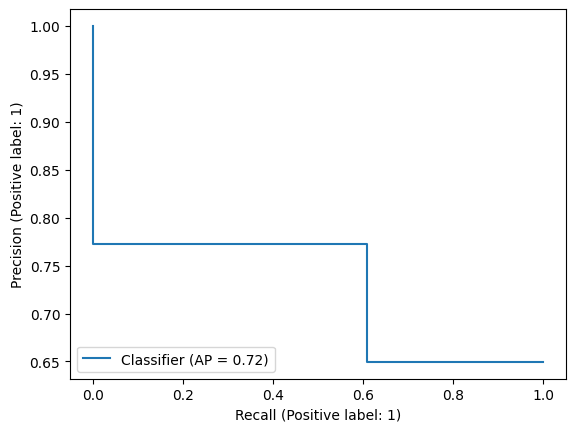

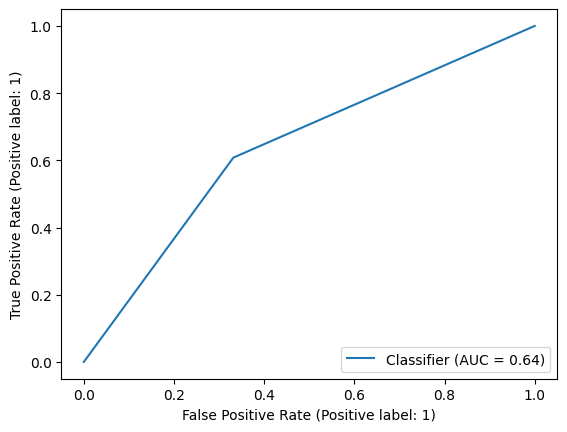

In [14]:

from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, roc_auc_score


prCurve = PrecisionRecallDisplay.from_predictions(predictionsTest, testY)
rocCurve = RocCurveDisplay.from_predictions(predictionsTest, testY)

aucROC = roc_auc_score(testY, predictionsTest)
print("AUC ROC: ", aucROC)

## NAIVE BAYES MULTINOMIAL

In [ ]:
nb = MultinomialNB()
nb.fit(trainingX, trainingY)

predictionsTrain = nb.predict(trainingX)
predictionTest = nb.predict(testX)

metricsTest = getMetrics(getConfusionMatrix(testY, predictionTest))
metricsTraing = getMetrics(getConfusionMatrix(trainingY, predictionsTrain))

print("\nNB Multinomial metrics on Training Set:")
printMetrics(metricsTraing)
print("\nNB Multinomial metrics on Test Set:")
printMetrics(metricsTest)

## KNN - K NEAREST NEIGHBORS

In [ ]:
def findBestK(lower, upper, metric="accuracy"):
    median = (lower + upper) // 2
    if lower == median:
        return lower
    
    results = dict()
    for k in [lower, median, upper]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(cuTrainingX, cuTrainingY)
        predicted = knn.predict(cuTestX)
        
        predicted = predicted.to_pandas().to_numpy().astype("bool")
        results[k] = getMetrics(getConfusionMatrix(cuTestY, predicted))[metric]

    if results[median] > results[lower]:
        return findBestK(median, upper, metric)
    else:
        return findBestK(lower, median, metric)

#!----------------------------------------------
    
bestK = findBestK(1, 1000, "accuracy")
print("Best K: ", bestK)

knn = KNeighborsClassifier(n_neighbors=bestK)
knn.fit(cuTrainingX, cuTrainingY)

predictedTrain = knn.predict(cuTrainingX)
predictedTest = knn.predict(cuTestX)

predictedTrain = predictedTrain.to_pandas().to_numpy().astype("bool")
predictedTest = predictedTest.to_pandas().to_numpy().astype("bool")

print("\nKNN Metrics on Training Set:")
printMetrics(getMetrics(getConfusionMatrix(cuTrainY, predictedTrain)))

print("\nKNN Metrics on Test Set:")
printMetrics(getMetrics(getConfusionMatrix(cuTestY, predictedTest)))

## CV - KNN - FOR FINDING BEST K

In [ ]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


f1 = make_scorer(f1_score, average="macro")
gs = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid={"n_neighbors": range(1, 32)}, scoring=f1, cv=5)

gs.fit(trainingX, trainingY)
bestK = gs.best_params_["n_neighbors"]

### KNN - K NEAREST NEIGHBORS - K = SQRT(N)

In [ ]:
knnSQRT = KNeighborsClassifier(n_neighbors=int(math.sqrt(len(cuTrainingX))))
knnSQRT.fit(cuTrainingX, cuTrainingY)

predictedTrain = knnSQRT.predict(cuTrainingX)
predictedTest = knnSQRT.predict(cuTestX)

predictedTrain = predictedTrain.to_pandas().to_numpy().astype("bool")
predictedTest = predictedTest.to_pandas().to_numpy().astype("bool")

print("\nKNN SQRT Metrics on Training Set:")
printMetrics(getMetrics(getConfusionMatrix(cuTrainY, predictedTrain)))

print("\nKNN SQRT Metrics on Test Set:")
printMetrics(getMetrics(getConfusionMatrix(cuTestY, predictedTest)))

## LINEAR SVM

In [ ]:
svm = cuLinearSVC(max_iter=100000)
svm.fit(cuTrainingX, cuTrainingY)

predictionsTrain = svm.predict(cuTrainingX)
predictionsTest = svm.predict(cuTestX)

predictionsTrain = predictionsTrain.to_pandas().to_numpy().astype("bool")
predictionsTest = predictionsTest.to_pandas().to_numpy().astype("bool")

metricsTrain = getMetrics(getConfusionMatrix(cuTrainY, predictionsTrain))
metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictionsTest))

print("\nLinear SVM metrics (GPU) on Training Set:")
printMetrics(metricsTrain)
print("\nLinear SVM metrics (GPU) on Test Set:")
printMetrics(metricsTest)

## SVM

In [ ]:
results = dict()
kernels = ["poly", "rbf", "sigmoid"]

for kernel in kernels:
    svm = cuSVC(kernel=kernel, max_iter=100000)
    svm.fit(cuTrainingX, cuTrainingY)

    predictionsTrain = svm.predict(cuTrainingX)
    predictionsTest = svm.predict(cuTestX)
    
    predictionsTrain = predictionsTrain.to_pandas().to_numpy().astype("bool")
    predictionsTest = predictionsTest.to_pandas().to_numpy().astype("bool")

    metricsTrain = getMetrics(getConfusionMatrix(cuTrainY, predictionsTrain))
    metricsTest = getMetrics(getConfusionMatrix(cuTestY, predictionsTest))
    
    print("\n SVM con kernel '" + kernel + "' metrics on Training Set: ")
    printMetrics(metricsTrain)
    print("\n SVM con kernel '" + kernel + "' metrics on Test Set: ")
    printMetrics(metricsTest)

## LOGISTIC REGRESSION

In [ ]:
totalMetrics = dict()
solvers = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]

for solver in solvers:
    lr = LogisticRegression(max_iter=100000, solver=solver)
    lr.fit(trainingX, trainingY)
    
    predictionsTrain = lr.predict(trainingX)
    predictionsTest = lr.predict(testX)

    metricsTest = getMetrics(getConfusionMatrix(testY, predictionsTest))
    metricsTrain = getMetrics(getConfusionMatrix(trainingY, predictionsTrain))
    
    totalMetrics[solver] = (metricsTrain, metricsTest)

    print("\nLogistic Regression metrics (solver = \"" + solver + "\") on Training Set:")
    printMetrics(metricsTrain)
    print("\nLogistic Regression metrics (solver = \"" + solver + "\") on Test Set:")
    printMetrics(metricsTest)